В файле dataset.csv можно найти синтетическую выборку. Она содержит 5 признаков и целевую переменную.

Требуется обучить на этих данных классификатор с как можно более высокой обобщающей способностью. Метрикой, по которой будет оцениваться качество классификатора, является ROC-AUC. Стоит заранее отметить, что если не удаётся получить ROC-AUC выше 70%, то это означает, что не придуманы какие-то сильные признаки. При этом предлагается уделить внимание не только точности классификатора, но и оформлению кода, изучению данных и грамотной оценке качества получившейся модели - всё это тоже будет оцениваться, а что-то из этого также может помочь построить более хорошую модель.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1n3_s-MAVuZCGsfqmU9RhoUYcnM_QU4o2NQvAmVfwgpc/edit?usp=sharing'
id = url.split('/')[5]
df = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{id}/export?format=csv')

In [3]:
df.sample(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,target
2255,-3.424256,7.841413,-2.681939,-1.433420,-9.302646,0
684,2.087213,1.868107,3.045396,-3.720215,10.631993,1
329,0.383712,2.941527,-10.046604,-2.754421,8.870124,1


In [4]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000
mean,0.141861,0.042065,0.022336,0.023745,0.025611,0.60000
std,5.433073,5.389536,5.422549,5.340603,5.434483,0.48998
min,-12.936886,-12.810592,-13.454282,-13.194904,-13.433194,0.00000
25%,-4.095531,-4.044539,-4.101664,-4.076794,-3.951466,0.00000
50%,0.182078,0.082622,-0.024358,0.068921,0.032573,1.00000
75%,4.213366,4.009051,4.095432,4.136638,4.312101,1.00000
max,13.093660,13.866223,13.907629,13.360422,13.649220,1.00000


Выводы:  датасет из 3000 тысяч строк. 5 фич, бинарная классификация. Соотношение классов 1/0 = 0.6. Самое инетресное: фичи почи идентичны или очень похожи в минимумах, максимумах и стандартном отклонении, минимумы и максимумы почти симметричны. А также среднее - около 0.

In [5]:
df.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'target'],
      dtype='object')

In [6]:
X_col = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

In [7]:
X = df[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y= df['target']

In [8]:
X_0 = df.query('target==0')[X_col]

In [9]:
X_0.head()

,feature_1,feature_2,feature_3,feature_4,feature_5
1,-0.216705,3.832332,-10.054348,-1.106758,1.987823
3,7.673529,-4.234502,8.135008,3.748393,3.457908
7,3.193706,-7.175935,10.066010,2.445733,-0.004250
8,0.452203,0.282056,10.971531,0.574770,-0.105325
11,-3.395802,-3.845678,1.973631,-9.495809,0.783373


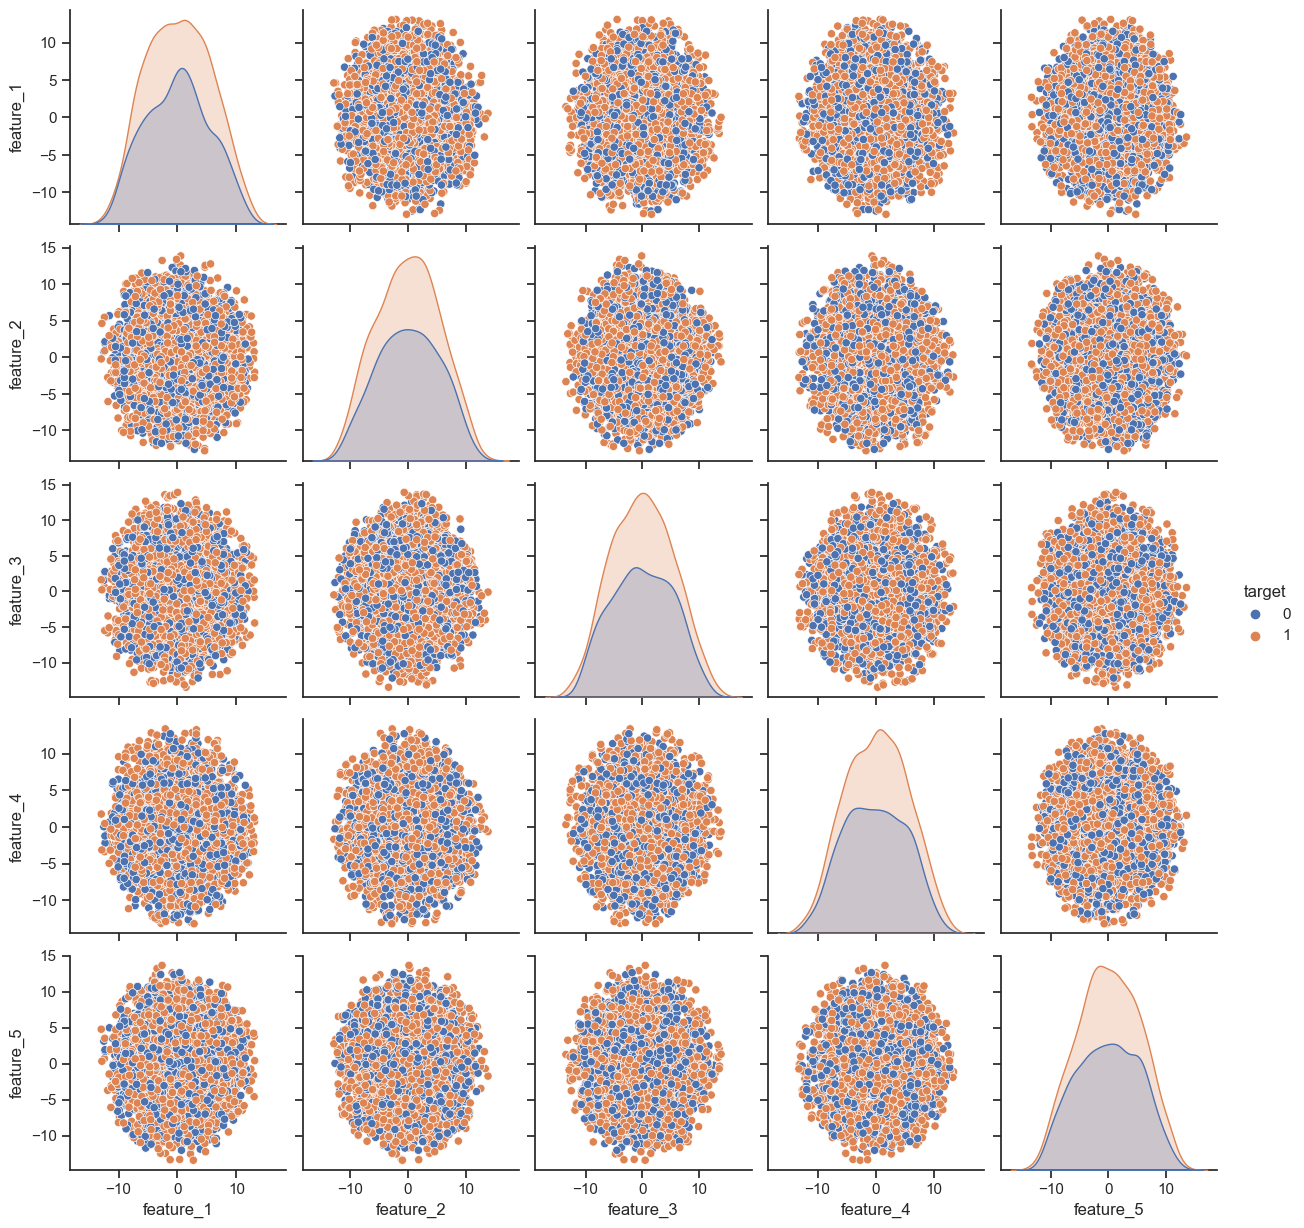

In [10]:
sns.pairplot(df, hue='target')
plt.show()

Заметим, что имеем некое равномерное распределение вокруг начала координат. На графике оно сжато из-за разного масштабов осей, но по факту имеет форму круга. Подобные графики мы бы получили, если рассматривали например равномерное распределение точек на сфере в трехмерном пространстве (спроецировли бы точки на кукую то из плоскостей системы координат, напр. XY).
В то же время мы наблюдаем близкие по значению минимумы и максимумы признаков, они близки к симметрии относительно 0. В дмумерной подобное распределение с учетом распределение в области окружности и равноудаленности - окружность. В трехмерном - сфера, в 5-ти мерном - 5-мерная сфера. Попробуем развить данную мысль.

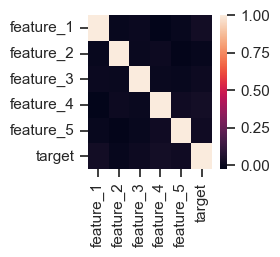

In [11]:
plt.figure(figsize=(2, 2))
heatmap = sns.heatmap(df.corr())
plt.show()

Ничего интересного.

Если запустить CatBoost или RandomForest, показатели точности модели будут очень малы. Необходим другой подход в решении задачи. 

Разделяем выборку

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

Попробуем рассматривать фичи как набор координат точек многомерного пространства и использовать расстояние от начала координато до этих точек для выявления закономерности.
Вводим новую фичу - евклидово расстояние, считая что 5 фич - набор координат точки в 5-мерном пространстве

In [13]:
y_test

1283    1
250     1
2153    1
2786    1
632     1
       ..
256     1
1686    1
341     0
1069    0
1044    1
Name: target, Length: 750, dtype: int64

In [14]:
df['distance'] = (df['feature_1']**2 + df['feature_2']**2 + 
                  df['feature_3']**2 + df['feature_4']**2 +
                 df['feature_5']**2)**0.5
df['distance'] = df['distance'].round(1)

In [15]:
df.head(2)

,feature_1,feature_2,feature_3,feature_4,feature_5,target,distance
0,0.433306,-4.106981,1.252722,4.842634,7.610817,1,10.0
1,-0.216705,3.832332,-10.054348,-1.106758,1.987823,0,11.0


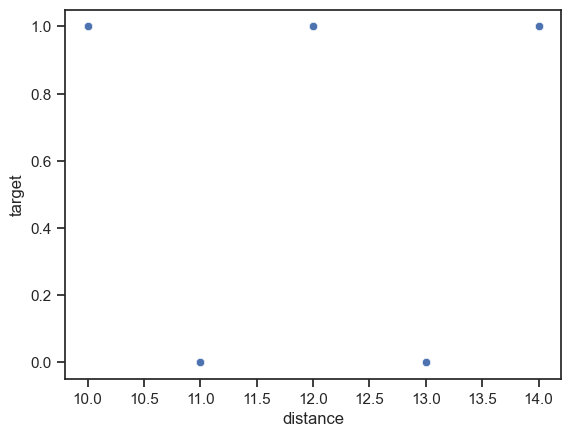

<Figure size 1500x400 with 0 Axes>

In [16]:
sns.scatterplot(data = df, x=df['distance'], y=df['target'])
plt.figure(figsize=(15, 4))
plt.show()

In [17]:
df['distance'].value_counts()

10.0    600
11.0    600
14.0    600
13.0    600
12.0    600
Name: distance, dtype: int64

Результат: имеем идеальное разделение классов в зависимости от фичи distance. Классификация при этом тривиальна: четное значение - класс 1, нечетное - класс 0. Получается своего рода "матрешка" из 5-мерных сфер.

Напишем простой класс, который лишь будет уметь на основании фич вывадать принадлежность к классу.

In [18]:
class SphereClassificator:
    
    def __init__(self):
        pass
    
    def predict(self, df):
        if 'distance' not in df.columns:
            df['distance'] = ((df['feature_1']**2 + df['feature_2']**2 + 
                  df['feature_3']**2 + df['feature_4']**2 +
                  df['feature_5']**2)**0.5).round(1)
        self.df = df    
        self.predictions = self.df['distance'].apply(lambda x: 1.0 if x%2==0 else 0.0).to_numpy()
        return self.predictions      
            

In [19]:
model = SphereClassificator()

In [20]:
roc_auc_score(y_test, model.predict(X_test))

1.0

Добились идеального результата. Модель будет обощать схожего типа данные.
Очень интересная задача, которую сложно решить стандартными методами ML. Задача была подготовленна с энтузиазмом и хитринокй :) 